In [2]:
pip install surprise

     |████████████████████████████████| 6.5MB 2.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678204 sha256=de5bf59bf6f4129822e6a70fbc7ecad1359ff20cf877c9c41e12181d1f07be0c
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
# import packages
import numpy as np 
import pandas as pd 
import os 
from matplotlib import pyplot as plt
import warnings
import time
from scipy.sparse import coo_matrix
warnings.filterwarnings('ignore')

from surprise.dataset import Dataset
from surprise.similarities import pearson
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import BaselineOnly

from surprise import Reader
from surprise.model_selection.split import KFold, train_test_split
from surprise.accuracy import mse, rmse
from sklearn import metrics

In [0]:
#data_directory = r'/Users/rover/Desktop/2020 Winter/ECE 219/Project 3/ml-latest-small'
#os.chdir(data_directory)

# links = pd.read_csv('links.csv')
# movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv') # only movie rating is used in this project
tags = pd.read_csv('tags.csv') # used for movie genre

num_movie = len(ratings['movieId'].unique())
num_user = len(ratings['userId'].unique())

# create rating matrix R
matrix = coo_matrix((ratings.rating.to_list(), (ratings.userId.to_list(), ratings.movieId.to_list()))).toarray()
R = pd.DataFrame(index = range(611), columns= ratings['movieId'].unique(), data = matrix[:, ratings.movieId.unique()])
R = R.drop(R.index[0])
R.replace(0, np.nan, inplace = True)


$\textbf{Question 34}$: Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

In [9]:
file_path = os.path.expanduser('ratings.csv')
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = True)

# use k = ? from problem 10
sim_opt = {'name': 'pearson_baseline', 'user_based': False}
knn_34 = knns.KNNBaseline(k = 20, sim_options = sim_opt)
knn_34.fit(data_train)
knn_pred = knn_34.test(data_test)

# use k = ? from problem 17
mf_34 = SVD(n_factors = 3)
mf_34.fit(data_train)
mf_pred = mf_34.test(data_test)

# compute latent factors of movies using NMF
nmf_34 = NMF(n_factors = 20)
nmf_34.fit(data_train)
nmf_pred = nmf_34.test(data_test)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


 Area under the curve for KNN is,  0.808781701280459
 Area under the curve for NMF is,  0.7733566262583241
 Area under the curve for MF is,  0.7930927749236871


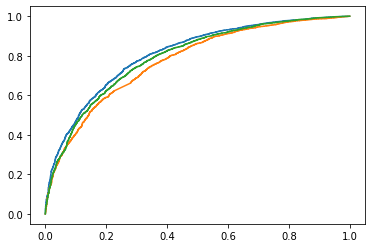

In [13]:
from sklearn.metrics import roc_curve, auc
plt.figure()

#KNN
trueValue = []
predValue = []

for i in range(len(data_test)):
    if data_test[i][2] >= 3: #threshold
        trueValue.append(1)
    else:
        trueValue.append(0)

    predValue.append(knn_pred[i][3])

fpr, tpr, thresholds = roc_curve(trueValue,predValue)
roc_auc = auc(fpr, tpr)
print (" Area under the curve for KNN is, ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve for KNN')

#NMF
trueValue = []
predValue = []

for i in range(len(data_test)):
    if data_test[i][2] >= 3: #threshold
        trueValue.append(1)
    else:
        trueValue.append(0)

    predValue.append(nmf_pred[i][3])

fpr, tpr, thresholds = roc_curve(trueValue,predValue)
roc_auc = auc(fpr, tpr)
print (" Area under the curve for NMF is, ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve for NMF')


#MF
trueValue = []
predValue = []

for i in range(len(data_test)):
    if data_test[i][2] >= 3: #threshold
        trueValue.append(1)
    else:
        trueValue.append(0)

    predValue.append(mf_pred[i][3])

fpr, tpr, thresholds = roc_curve(trueValue,predValue)
roc_auc = auc(fpr, tpr)
print (" Area under the curve for MF is, ", roc_auc)
plt.plot(fpr, tpr, label='ROC curve for MF')


$\textbf{Question 35}$: Precision and Recall are defined by the mathematical expres- sions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.

In [0]:
from collections import defaultdict
def precision_recall(predictions, t, threshold=3):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}
    recalls = {}
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of recommended items
        n_rec_k = t
        
        # Number of relevant and recommended items in top t
        n_rel_and_rec_k = 0
        for i in range(t):
            if user_ratings[i][1] >= threshold:
                n_rel_and_rec_k += 1
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Precision
        precisions[uid] = n_rel_and_rec_k / n_rec_k

        # Recall
        recalls[uid] = n_rel_and_rec_k / n_rel

    return precisions, recalls

def testset_trim(testset, t, threshold=3):
    count = {}
    likes = {}
    
    for (u, i, r) in testset:
        if u not in count:
            count[u] = 0
        count[u] += 1
        if u not in likes:
            likes[u] = 0
        if r >= threshold:
            likes[u] += 1
            
    res = []
    for (u, i, r) in testset:
        if count[u] >= t and likes[u] > 0:
            res.append((u, i, r))
    
    return res
def draw_precision_recall(y_axis, x_axis, y_axis_label, x_axis_label,title):
    plt.gcf().clear()
    plt.figure(figsize=(12,9))
    plt.plot(x_axis,y_axis)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.show()


In [0]:
min_k_knn = 20 #knn_ks[min_knn_MAE][0] Problem 11
min_k_nmf = 20 #nmf_ks[nmf_min_RMSE][0] Problem 18
min_k_nmf_biased = 3 #nmf_ks[nmf_min_RMSE_biased][0] Problem 25

file_path = os.path.expanduser('ratings.csv')
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

$\textbf{Question 36}$: Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using k-NN collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.


In [27]:
threshold = 3
kf = KFold(n_splits=10)
ts = [i for i in range(1, 25 + 1)]
knn_precision = []
knn_recall = []
for t in ts:
    temp_prec = []
    temp_recall = []

    for trainset, testset in kf.split(data):
        sim_opt = {'name': 'pearson_baseline', 'user_based': False}
        knn_34 = knns.KNNWithMeans(k = min_k_knn, sim_options = sim_opt)
        knn_34.fit(trainset)
        knn_pred = knn_34.test(testset)
    
        precisions, recalls = precision_recall(knn_pred, t)
        fold_mean_prec = sum(prec for prec in precisions.values()) / len(precisions)
        fold_mean_recall = sum(rec for rec in recalls.values()) / len(recalls)
            
        temp_prec.append(fold_mean_prec)
        temp_recall.append(fold_mean_recall)
    
    t_mean_prec = sum(prec for prec in temp_prec) / len(temp_prec)
    t_mean_recall = sum(rec for rec in temp_recall) / len(temp_recall)
    knn_precision.append(t_mean_prec)
    knn_recall.append(t_mean_recall)
draw_precision_recall(knn_precision, ts, 'Precision', 't','kNN - Precision against t')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


ZeroDivisionError: ignored

$\textbf{Question 37}$: Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using NNMF-based collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use optimal number of latent factors found in question 18 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.


$\textbf{Question 38}$: Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using MF with bias-based collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use optimal number of latent factors found in question 25 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.

$\textbf{Question 39}$: Plot the precision-recall curve obtained in questions 36,37, and 38 in the same figure. Use this figure to compare the relevance of the recom- mendation list generated using k-NN, NNMF, and MF with bias predictions.
